# <p style="background-color:#000080; font-family:calibri; color:white; padding-top: 30px; padding-bottom: 30px;font-size:100%; text-align:center; border-radius:15px 50px;"> E-commerce Product </p>


# <p style="background-color:#4169E1; font-family:calibri; padding-top: 10px; padding-bottom: 10px; margin-right: 50px; margin-left: 50px; color:white; font-size:70%; text-align:center; border-radius:15px 50px;">Step 1 | Import Libraries</p>


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from common_function import common_functions,train_and_evaluate_multiple_models
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump

# <p style="background-color:#4169E1; font-family:calibri; padding-top: 10px; padding-bottom: 10px; margin-right: 50px; margin-left: 50px; color:white; font-size:70%; text-align:center; border-radius:15px 50px;">Step 2 | Load Data And Read Data </p>


In [2]:
data = pd.read_csv("E_Commerce.csv")
common_fun = common_functions()

In [3]:
data.duplicated().value_counts()

False    10999
Name: count, dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [5]:
data.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [6]:
data = data.drop(columns=['ID'])

In [7]:
data['Reached.on.Time_Y.N'].value_counts().unique()

array([6563, 4436], dtype=int64)

# <p style="background-color:#4169E1; font-family:calibri; padding-top: 10px; padding-bottom: 10px; margin-right: 50px; margin-left: 50px; color:white; font-size:70%; text-align:center; border-radius:15px 50px;">Step 3 | Get Correlation of "Churn" with other variables </p>


<h3 style="color:#ADD8E6;">Step 3-1: Count all Int and Float columns </h3>


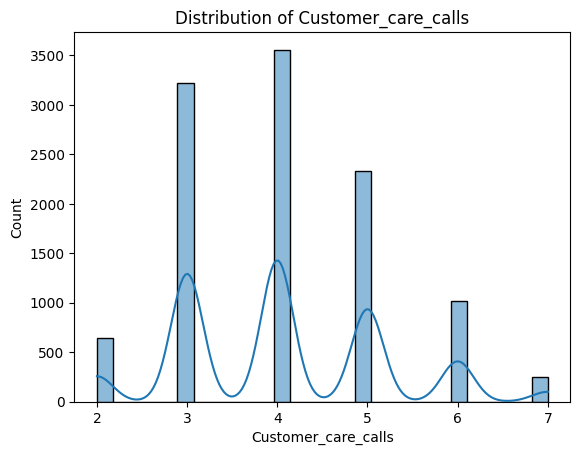

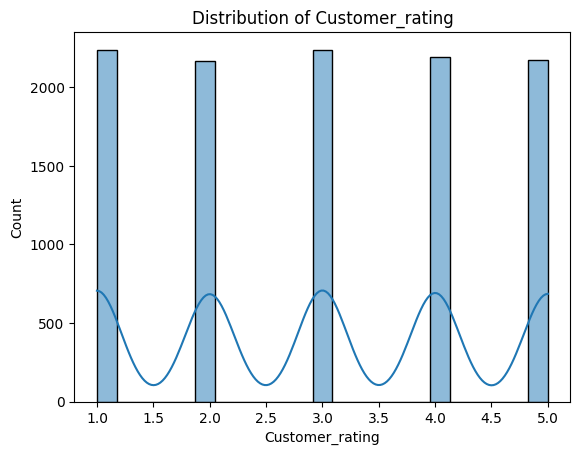

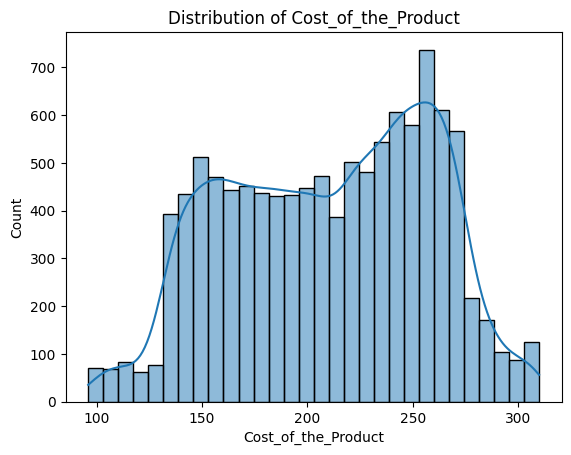

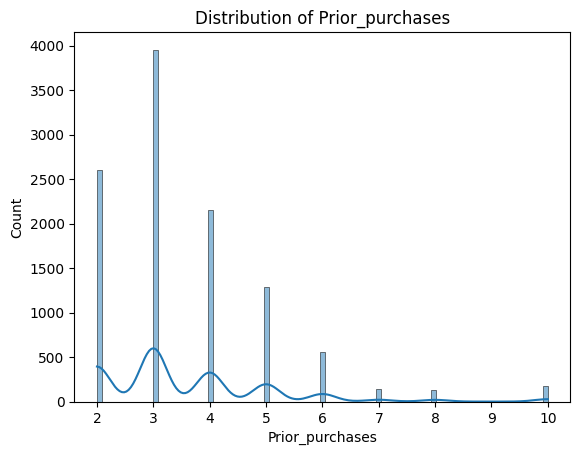

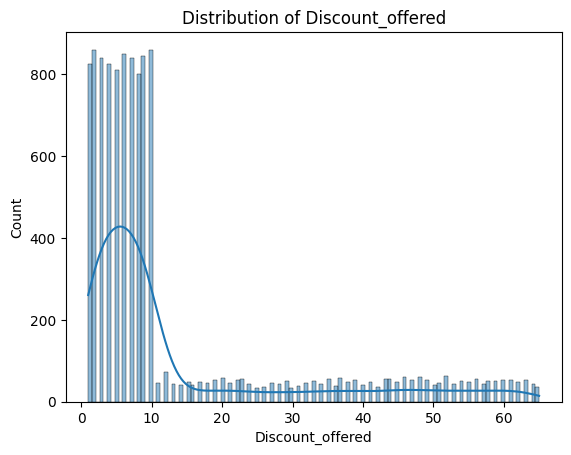

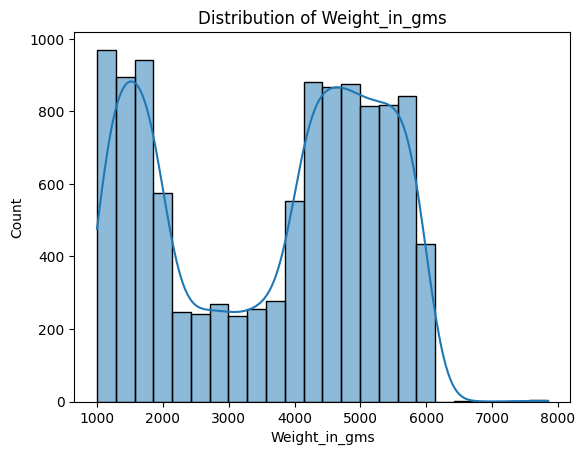

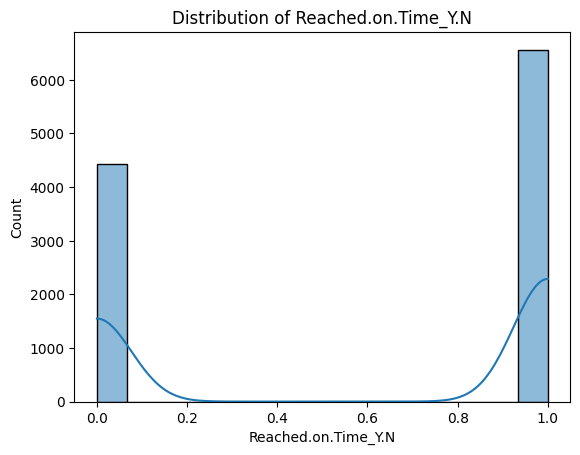

In [8]:
for column in data.select_dtypes(include=['int64', 'float64']).columns:
    sns.histplot(data[column], kde=True)
    plt.title(f"Distribution of {column}")
    plt.show()

<h3 style="color:#ADD8E6;">Step 3-2: Count all object value columns </h3>


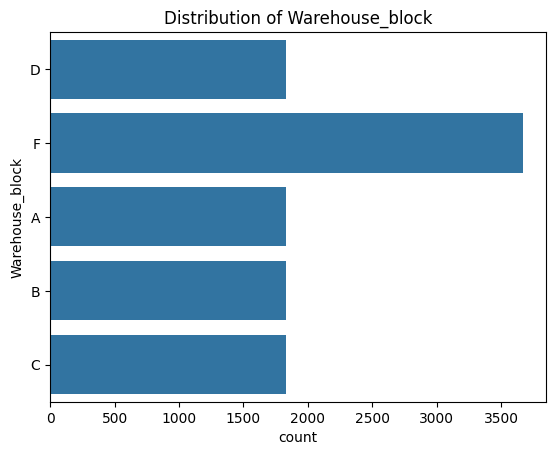

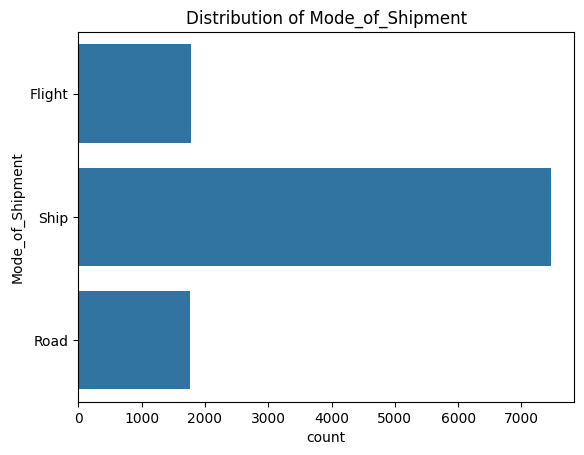

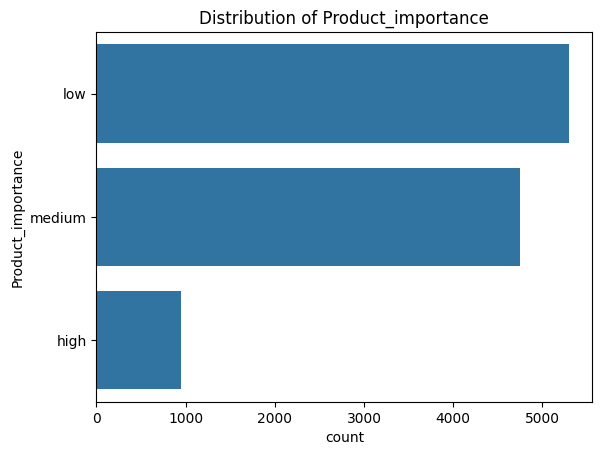

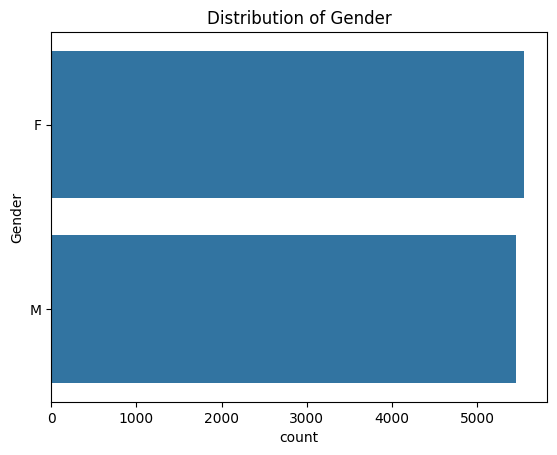

In [9]:
for column in data.select_dtypes(include=['object']).columns:
    sns.countplot(data[column])
    plt.title(f"Distribution of {column}")
    plt.show()

<h3 style="color:#ADD8E6;">Step 3-3: Visualizing Product Cost by Warehouse Block and Delivery Timeliness</h3>


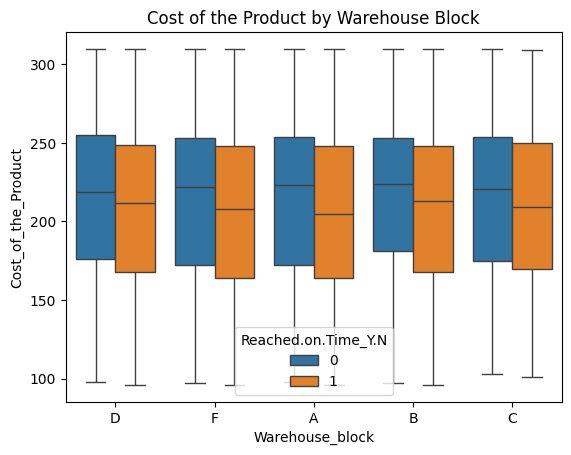

In [10]:
sns.boxplot(x='Warehouse_block', y='Cost_of_the_Product', data=data, hue='Reached.on.Time_Y.N')
plt.title("Cost of the Product by Warehouse Block")
plt.show()

<h3 style="color:#ADD8E6;">Step 3-4: Analyzing Average Product Weight by Warehouse Block and Delivery Timeliness</h3>


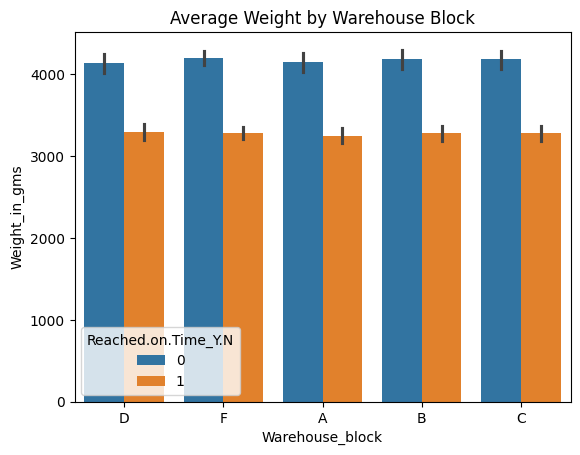

In [11]:
sns.barplot(x='Warehouse_block', y='Weight_in_gms', hue='Reached.on.Time_Y.N', data=data)
plt.title("Average Weight by Warehouse Block")
plt.show()

<h3 style="color:#ADD8E6;">Step 3-5: Shipment Mode Distribution by Delivery Timeliness</h3>


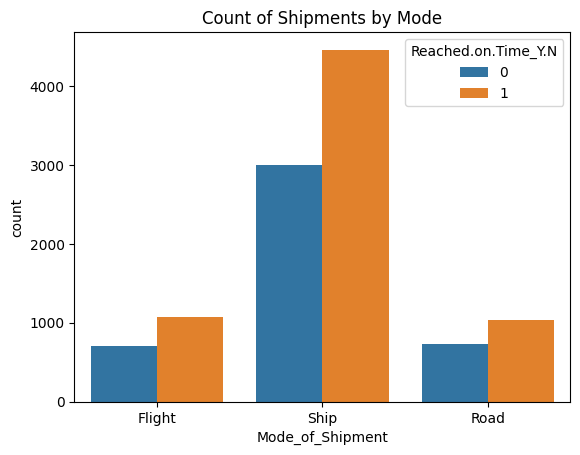

In [12]:
sns.countplot(x='Mode_of_Shipment', hue='Reached.on.Time_Y.N', data=data)
plt.title("Count of Shipments by Mode")
plt.show()

<h3 style="color:#ADD8E6;">Step 3-6: Heatmap </h3>


In [13]:
data = common_fun.all_label_encode(data)

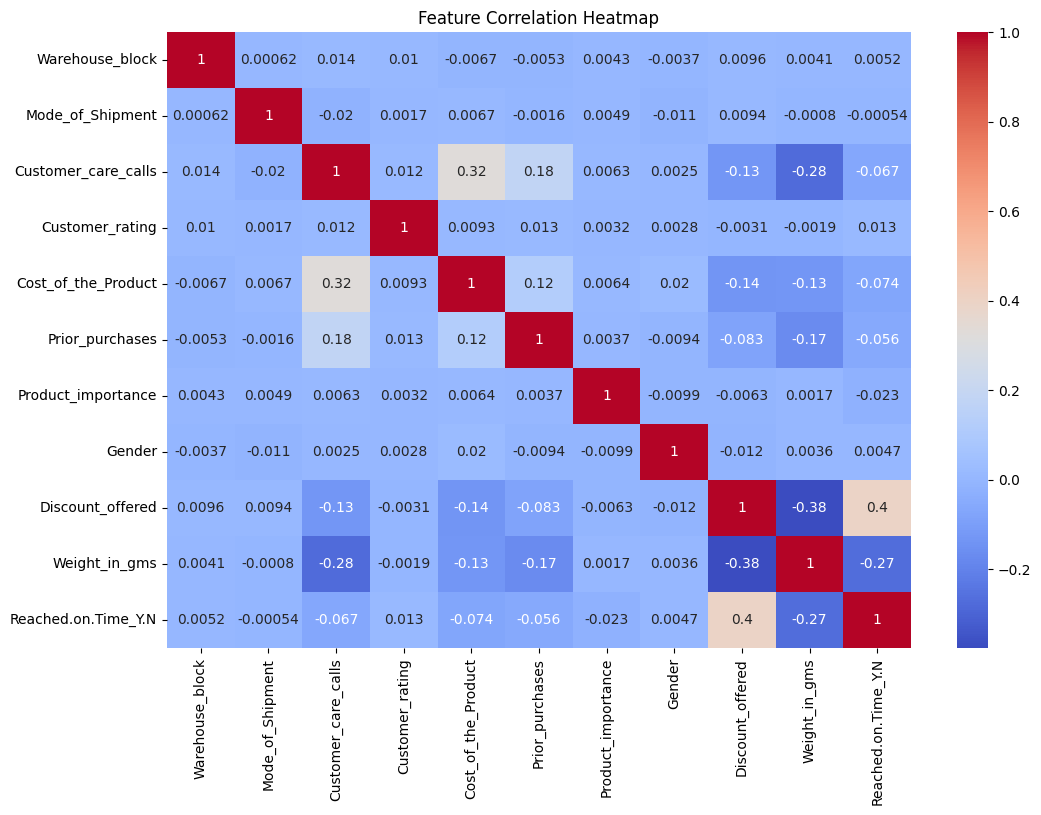

In [14]:
plt.figure(figsize=(12, 8))

sns.heatmap(data.corr(), annot=True, cmap="coolwarm",)
plt.title("Feature Correlation Heatmap")
plt.show()


# <p style="background-color:#4169E1; font-family:calibri; padding-top: 10px; padding-bottom: 10px; margin-right: 50px; margin-left: 50px; color:white; font-size:70%; text-align:center; border-radius:15px 50px;">Step 4 | Train And Evaluate Model </p>


<h3 style="color:#ADD8E6;">Step 4-1: Separating Features and Target for Model Training</h3>


In [15]:
X = data.drop(columns=['Reached.on.Time_Y.N'])
y = data['Reached.on.Time_Y.N']

<h3 style="color:#ADD8E6;">Step 4-2: Split the dataset into training and testing sets</h3>


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h3 style="color:#ADD8E6;">Step 4-3: GridSearchCV for Hyperparameter Tuning Across Multiple Models </h3>


In [17]:
model_params = {
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [10, 50, 100],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
        },
    },
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"],
            "max_iter": [100, 200],
        },
    },
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
            "criterion": ["gini", "entropy"],
        },
    },
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "p": [1, 2],
        },
    },
}

results = {}
for model_name, mp in model_params.items():
    grid = GridSearchCV(mp["model"], mp["params"], cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    results[model_name] = {
        "best_params": grid.best_params_,
        "best_score": grid.best_score_,
    }
    

    print(f"\n{model_name} Best Parameters: {grid.best_params_}")
    print(f"{model_name} Best Cross-Validation Score: {grid.best_score_:.4f}")



RandomForestClassifier Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
RandomForestClassifier Best Cross-Validation Score: 0.6717

LogisticRegression Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
LogisticRegression Best Cross-Validation Score: 0.6427

DecisionTreeClassifier Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
DecisionTreeClassifier Best Cross-Validation Score: 0.6660

KNeighborsClassifier Best Parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
KNeighborsClassifier Best Cross-Validation Score: 0.6539


<h3 style="color:#ADD8E6;">Step 4-4: Summary of Best Parameters and Cross-Validation Scores for Models</h3>


In [18]:
print("\nSummary of GridSearchCV Results:")
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Best Parameters: {result['best_params']}")
    print(f"  Best CV Score: {result['best_score']:.4f}")


Summary of GridSearchCV Results:
RandomForestClassifier:
  Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
  Best CV Score: 0.6717
LogisticRegression:
  Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
  Best CV Score: 0.6427
DecisionTreeClassifier:
  Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
  Best CV Score: 0.6660
KNeighborsClassifier:
  Best Parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
  Best CV Score: 0.6539


<h3 style="color:#ADD8E6;">Step 4-5: Extracting and Accessing Best Parameters from GridSearchCV Results </h3>


In [19]:
best_params_list = []
for model_name, result in results.items():
    best_params_list.append(result["best_params"])
best_params_list[0]

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}

<h3 style="color:#ADD8E6;">Step 4-6: Instantiating Models with Best Parameters and Evaluating Their Performance</h3>


In [20]:
rf = RandomForestClassifier(**best_params_list[0])
lr = LogisticRegression(**best_params_list[1])
dt = DecisionTreeClassifier(**best_params_list[2])
kn = KNeighborsClassifier(**best_params_list[3])

models = [
    rf,
    lr,
    DecisionTreeClassifier(**best_params_list[2]),
    KNeighborsClassifier(**best_params_list[3]),
]

results_reg = train_and_evaluate_multiple_models(models, X_train, X_test, y_train, y_test,return_y_pred=False)

Model: RandomForestClassifier (Classifier) -> Accuracy: 0.6854545454545454
Model: LogisticRegression (Classifier) -> Accuracy: 0.6345454545454545
Model: DecisionTreeClassifier (Classifier) -> Accuracy: 0.67
Model: KNeighborsClassifier (Classifier) -> Accuracy: 0.6568181818181819


<h3 style="color:#ADD8E6;">Step 4-7: Random Forest Hyperparameter Tuning Using GridSearchCV</h3>


In [21]:
RFmodel = RandomForestClassifier()
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=RFmodel,  
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  
)

<h3 style="color:#ADD8E6;">Step 4-8: Hyperparameter Tuning with GridSearchCV to Find the Best Model Parameters</h3>


In [22]:
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}


<h3 style="color:#ADD8E6;">Step 4-9: Training and Evaluating a Random Forest Classifier with Optimized Hyperparameters</h3>


In [23]:
RFmodel = RandomForestClassifier(random_state=42,**best_params)

RFmodel.fit(X_train, y_train)

y_pred = RFmodel.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6863636363636364
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.86      0.69       895
           1       0.86      0.56      0.68      1305

    accuracy                           0.69      2200
   macro avg       0.72      0.71      0.69      2200
weighted avg       0.74      0.69      0.69      2200



<h3 style="color:#ADD8E6;">Step 4-10: Comprehensive Classification Model Evaluation Function with Metrics and Visualization</h3>


In [24]:
def evaluate_model(model, x_test, y_test, model_name):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Check if the model has predict_proba
    if hasattr(model, "predict_proba"):
        auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    else:
        auc = "N/A"  # or you can set it to None if you prefer

    print("--- {model_name} Evaluation ---")
    print("Accuracy: {accuracy:.4f}")
    print("ROC-AUC: {auc if isinstance(auc, str) else auc:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1-Score": report['1']['f1-score'],
        "AUC-ROC": auc
    }

<h3 style="color:#ADD8E6;">Step 4-11: Comparative Evaluation of Classifier Models</h3>


--- {model_name} Evaluation ---
Accuracy: {accuracy:.4f}
ROC-AUC: {auc if isinstance(auc, str) else auc:.4f}
              precision    recall  f1-score   support

           0       0.55      0.58      0.56      3541
           1       0.71      0.68      0.69      5258

    accuracy                           0.64      8799
   macro avg       0.63      0.63      0.63      8799
weighted avg       0.64      0.64      0.64      8799



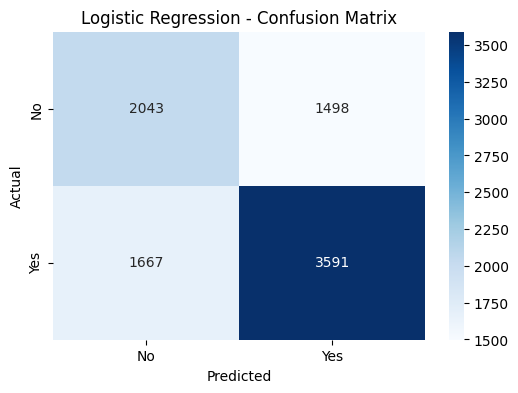

--- {model_name} Evaluation ---
Accuracy: {accuracy:.4f}
ROC-AUC: {auc if isinstance(auc, str) else auc:.4f}
              precision    recall  f1-score   support

           0       0.58      0.86      0.69       895
           1       0.86      0.56      0.68      1305

    accuracy                           0.69      2200
   macro avg       0.72      0.71      0.69      2200
weighted avg       0.74      0.69      0.69      2200



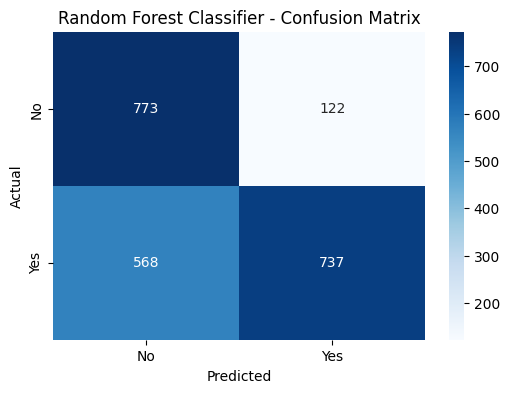

In [25]:
results = []

# Evaluate Logistic Regression
logreg_best = lr
results.append(evaluate_model(logreg_best, X_train, y_train, "Logistic Regression"))

# Evaluate Random Forest
rf_best = RFmodel
results.append(evaluate_model(rf_best, X_test, y_test, "Random Forest Classifier"))

# <p style="background-color:#4169E1; font-family:calibri; padding-top: 10px; padding-bottom: 10px; margin-right: 50px; margin-left: 50px; color:white; font-size:70%; text-align:center; border-radius:15px 50px;">Step 5 | Model Save </p>


In [26]:
dump(RFmodel, 'random_forest_model.joblib')

['random_forest_model.joblib']